# **--------------------  Task 1 ----------------------**

## **Importing Necessary Libraries**


In [1]:
# Importing Necessary Library including stop_words of English from corpus

import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import words

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Connecting to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Reading true and fake news from csv and merging them**

In [2]:
# Loading Data and merging two data along with adding label 0 and 1 to true and fake news

true_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")

true_news['label'] = 0
fake_news['label'] = 1
news_merged = pd.concat([true_news, fake_news], ignore_index=True)


### **1. Checking if there are any null (na) values in the data**

In [3]:
# check if any rows contains empty values

news_merged.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


### **2. Shuffling the merged data and saving it as news.csv**

In [4]:
# Shuffling all the rows and resetting index so that data are random
news = news_merged.sample(frac=1).reset_index(drop=True)
news.to_csv("news.csv")


In [5]:
news.text.head() # checking head of the news

,text
0,WASHINGTON (Reuters) - No newly elected admini...
1,By Jon RappoportCNN is already claiming the wh...
2,Court documents show deceptive behavior by Don...
3,KATHMANDU (Reuters) - A bus carrying passenger...
4,Pastor Kenneth Sharpton Glasgow claims he s Re...


In [6]:
news.info() # this also gives if any columns have null values and other descriptions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [5]:
# Regular expression pattern to capture newspaper name followed by "(Reuters)"
''' This is one of the pattern seen in the news ie newspaper name along with (Reuters).
    I made different columns (feature) along with replacement of the newspaper name with ''
    if it only captures newspaper name. Sometimes (Reuters) can be seen in the middle of the news
    which captures all the previous text, so implementing if number of characters are less than
    100 for the newspaper name  '''

pattern = r'^[1-9A-Za-z\s]+\(Reuters\)'

# Iterate over DataFrame rows
for idx, row in news.iterrows():
    match = re.match(pattern, row['text'])
    if match:
        newspaper = match.group()  # Capture the matched text
        news.at[idx, 'newspaper'] = newspaper  # Store it in the new 'newspaper' column

        # Check if the length of the match is less than 100 characters
        if len(newspaper) < 100:
            # Replace the matched text in 'text' column with a space
            news.at[idx, 'text'] = row['text'].replace(newspaper, ' ')
    else:
        news.at[idx, 'newspaper'] = None


In [6]:
''' Checking the frequent news paper. Also there are text without known newspaper name
    in that case they are assigned with None, so there are 27675 news without paper name
'''
print(news.newspaper.value_counts())
print(news.newspaper.isna().sum())

newspaper
WASHINGTON (Reuters)       6389
LONDON (Reuters)            705
NEW YORK (Reuters)          695
MOSCOW (Reuters)            623
BERLIN (Reuters)            499
                           ... 
San Diego (Reuters)           1
ATLANTIC CITY (Reuters)       1
DAMASCUS (Reuters)            1
NMADRID (Reuters)             1
MIDWAY ATOLL (Reuters)        1
Name: count, Length: 305, dtype: int64
27675


In [7]:
''' I made a column with weight based on the frequent newspaper, which might be used in future if used,
    and filled newspaper which doesn't have name to have the weight value to min
'''
news['weight'] = news.newspaper.map(news.newspaper.value_counts(normalize=True))
news['weight'] = news['weight'].fillna(news.weight.min())

In [10]:
news.head()

,title,text,subject,date,label,newspaper,weight
0,No new U.S. administration is completely prepa...,- No newly elected administration is totally...,politicsNews,"November 16, 2016",0,WASHINGTON (Reuters),0.370957
1,Rappoport: ‘CNN Already Deflecting From the Su...,By Jon RappoportCNN is already claiming the wh...,Middle-east,"April 4, 2017",1,None,0.000058
2,Court Documents Show How Trump Cooked The Boo...,Court documents show deceptive behavior by Don...,News,"August 13, 2016",1,None,0.000058
3,"Bus plunges into river in Nepal, killing at le...",- A bus carrying passengers returning from a...,worldnews,"October 28, 2017",0,KATHMANDU (Reuters),0.000523
4,WHY IS AL SHARPTON’S “Half-Brother” Registerin...,Pastor Kenneth Sharpton Glasgow claims he s Re...,politics,"Dec 1, 2017",1,None,0.000058


## **Text Preprocessing**

In [8]:
''' Though preprocessing has already started, but main text are preprocessed in this function'''

def preprocess_text(texts):

    # remove punctuations
    texts = re.sub(r'[^\w\s]', ' ', texts)

    #remove special characters
    texts = re.sub(r'[^a-zA-Z0-9\s]', ' ', texts)

    #remove digits
    texts = re.sub(r'\d', ' ', texts)

    #remove if there are any alphabet, symbol or anything repeated more than 2 times
    texts = re.sub(r'\b\w*(\w)\1{2,}\w*\b',' ', texts)

    # lower case
    texts = texts.lower()

    #remove all stopwords
    texts = ' '.join([word for word in texts.split() if word not in stop_words])

    # Remove extra whitespace
    texts = re.sub(r'\s+', ' ', texts).strip()

    return texts


In [9]:
# Preprocessing title only, it was used with ! sign representing important characteristics in the
# title
def preprocess_title(title):

    title = re.sub(r'\d', ' ', title) # remove all the digits
    title = re.sub(r'[^\w\s]', ' ', title) # remove special characters
    title = re.sub(r'\b\w*(\w)\1{2,}\w*\b',' ', title)
    ''' remove any word which has more than 2 consecutive repeated letters'''

    title = re.sub(r'\s+', ' ', title).strip() # remove extra white space

    title = ' '.join([word for word in title.split() if word not in stop_words]) # remove stop words
    title = title.lower() # convert all texts to lower case
    return title

In [10]:
# Preprocessing the main news
processed_text = news.text.apply(preprocess_text)

In [11]:
# Preprocessing the title
processed_title = news.title.apply(preprocess_title)

In [12]:
# Making different columns for processed text, and title so that main text doesn't change and saving the file
news['processed_text'] = processed_text
news['processed_title'] = processed_title
news.to_csv("processed_news.csv")

In [13]:
'''Since colab provided 12gb ram for execution, it started to crash due to memory overflow
so i saved the variable outputs like processed text, tfidf matrix for later use and execution
if required'''

import pickle

with open('processed_text.pkl', 'wb') as f:
    pickle.dump(processed_text, f)

with open('processed_title.pkl', 'wb') as f:
    pickle.dump(processed_title, f)

In [14]:
processed_text.head()

,text
0,daily show needs go fox news often jon stewart...
1,democrat hillary clinton percentage point lead...
2,hillary clinton campaign confronting emerging ...
3,compromise ability objective bill hillary clin...
4,amnesty international urged egyptian authoriti...


In [19]:
# tokenize the word for further processing

word_tokenized = processed_text.apply(word_tokenize)
word_tokenized.head()


,text
0,"[newly, elected, administration, totally, read..."
1,"[jon, rappoportcnn, already, claiming, whole, ..."
2,"[court, documents, show, deceptive, behavior, ..."
3,"[bus, carrying, passengers, returning, hindu, ..."
4,"[pastor, kenneth, sharpton, glasgow, claims, r..."


In [20]:
with open('word_tokenized.pkl', 'wb') as f:
    pickle.dump(word_tokenized, f)

# **--------------------  Task 2 ----------------------**

In [22]:
# with open('tfidf_matrix.pkl', 'wb') as f:
#     pickle.dump(tfidf_matrix, f)

In [23]:
# recovering the variable after it started crashing
import pickle

# filenames = ['processed_text.pkl', 'word_tokenized.pkl','tfidf_matrix.pkl']

# # Dictionary to hold loaded variables
# loaded_data = {}

# # Load each file and store in the dictionary
# for filename in filenames:
#     with open(filename, 'rb') as f:
#         variable_name = filename.split('.')[0]  # Get the variable name from the filename
#         loaded_data[variable_name] = pickle.load(f)

# # Access the loaded variables
# # word_tokenized = loaded_data['word_tokenized']
# # processed_text = loaded_data['processed_text']
# # tfidf_matrix = loaded_data['tfidf_matrix']

In [25]:
# test model on naive bayes with held out test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# plot aur roc curve
def test_model(model, X_test, y_test):

    y_pred_model = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model)
    recall = recall_score(y_test, y_pred_model)
    f1 = f1_score(y_test, y_pred_model)
    roc_auc = roc_auc_score(y_test, y_pred_model)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

    # plot
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_model)

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    plt.legend()
    plt.show()

In [26]:
# since TfidfVectorizer directly took processed_text as input, tokenizing was not necessary
# converting text into TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the tokenized texts
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_text)

In [39]:
# using both CountVectorizer and Tfidf for comparision
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the tokenized texts
count_matrix = count_vectorizer.fit_transform(processed_text)

In [40]:
# train test split and keep 5000 random rows as held-out test set, tested with both count vectorizer and tfidf

from sklearn.model_selection import train_test_split

# select processed_title, processed_text as features
target = news.label
X_train, X_test, y_train, y_test = train_test_split(count_matrix, target, test_size=5000, random_state=2)


In [41]:
# apply naive bayes on the features and target with and without cross fold
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes model initializing
model_without_kf = MultinomialNB()

# Fitting the model on the training data
model_without_kf.fit(X_train, y_train)

MultinomialNB()

Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-score: 0.95
ROC AUC: 0.95


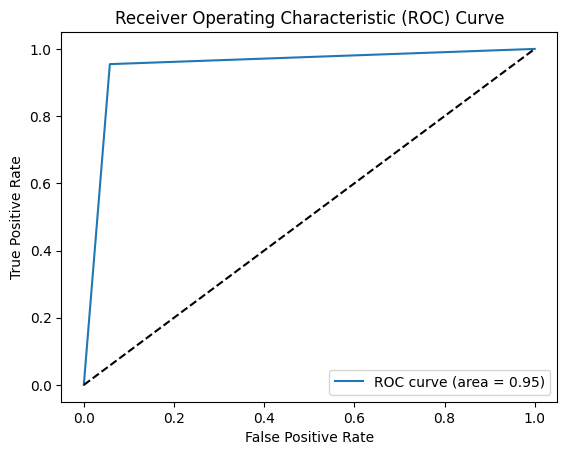

In [43]:
# test model on naive bayes
test_model(model_without_kf, X_test, y_test)

In [45]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred_without_kf = model_without_kf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_without_kf)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print(classification_report(y_test, y_pred_without_kf))

Accuracy: 94.88%
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2392
           1       0.95      0.95      0.95      2608

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



In [46]:
# Using StratifiedKFold rather than Kfold in order to prevent biasness
from sklearn.model_selection import StratifiedKFold

import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=False) # Data not shuffled because of earlier shuffling


Average Validation Accuracy: 94.77%
Test Accuracy: 94.82%


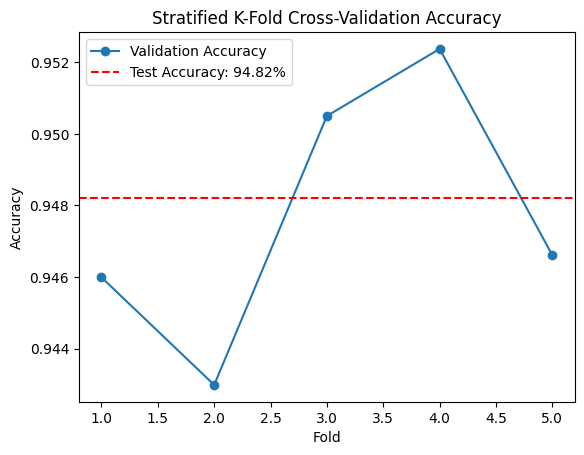

In [54]:
# List to store accuracy for each fold
accuracy_scores = []

# Initialize the model
model_with_kf = MultinomialNB()

# Perform Stratified K-Fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_fold_train, X_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]


    # Fit the model on the training data
    model_with_kf.fit(X_fold_train, y_fold_train)

    # Validate the model on the validation set
    y_val_pred = model_with_kf.predict(X_val)

    # Calculate accuracy for the validation set
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)

# Calculate the average accuracy across all folds
average_validation_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f'Average Validation Accuracy: {average_validation_accuracy * 100:.2f}%')

# Final evaluation on the test set
y_test_pred_with_kf = model_with_kf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_with_kf)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# accuracy of validation set and final test accuracy
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Stratified K-Fold Cross-Validation Accuracy')

# plot test set accuracy as well
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy * 100:.2f}%')

plt.legend()
plt.show()






Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-score: 0.95
ROC AUC: 0.95


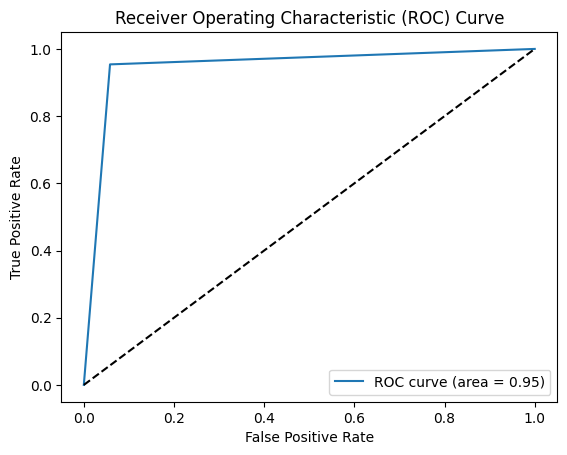

In [55]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Make predictions on the test set
y_pred_with_kf = model_with_kf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_with_kf)
precision = precision_score(y_test, y_pred_with_kf)
recall = recall_score(y_test, y_pred_with_kf)
f1 = f1_score(y_test, y_pred_with_kf)
roc_auc = roc_auc_score(y_test, y_pred_with_kf)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# plot the ROC_AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_with_kf)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend()
plt.show()






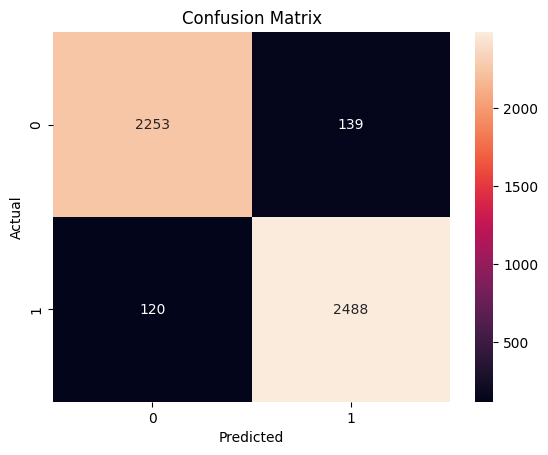

In [66]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_with_kf)

#heatmap of confusion matrix
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# testing accuracy on train data
y_train_pred_with_kf = model_with_kf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred_with_kf)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

Train Accuracy: 95.54%


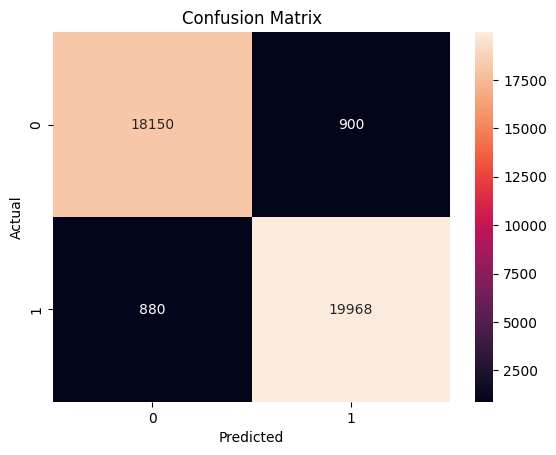

In [33]:
# plotting confusion matrix on prediction with cross fold
cm_train = confusion_matrix(y_train, y_train_pred_with_kf)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Checking if actual news(text) works better on classification or the title

title_count_vectorizer = CountVectorizer() # count vectorizer of title only
title_count_matrix = title_count_vectorizer.fit_transform(processed_title)

#converting to dataframe
title_count_df = pd.DataFrame(title_count_matrix.toarray(), columns=title_count_vectorizer.get_feature_names_out())


Accuracy: 0.97
Precision: 0.97
Recall: 0.98
F1-score: 0.97
ROC AUC: 0.97


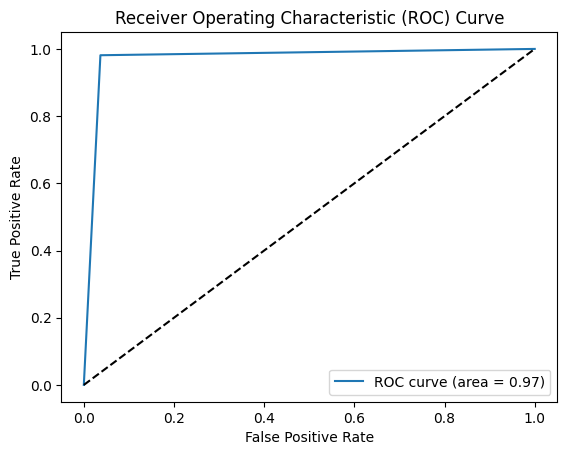

In [58]:
# spliting the count vectorizer of title into train test
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(title_count_matrix, target, test_size=5000, random_state=2)

title_model_without_kt = MultinomialNB()
title_model_without_kt.fit(X_train_title, y_train_title)
title_model_without_kt.score(X_test_title, y_test_title)

test_model(title_model_without_kt, X_test_title, y_test_title)
# better accuracy observed

#### **---------Higher Accuracy observed on title------------**

In [36]:
# checking with tfidfvectorizer on title using cross validation

title_tfidf_vectorizer = TfidfVectorizer()
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(processed_title)

title_count_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=title_count_vectorizer.get_feature_names_out())


In [37]:
title_accuracy_score = []
title_model_with_kf = MultinomialNB()

# using stratified k fold on the title splited data
for train_index, val_index in skf.split(X_train_title, y_train_title):
    X_fold_train, X_val = X_train_title[train_index], X_train_title[val_index]
    y_fold_train, y_val = y_train_title.iloc[train_index], y_train_title.iloc[val_index]

    title_model_with_kf.fit(X_fold_train, y_fold_train)
    y_val_pred = title_model_with_kf.predict(X_val)

    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    title_accuracy_score.append(accuracy)

average_validation_accuracy = sum(title_accuracy_score) / len(title_accuracy_score)
print(f'Average Validation Accuracy: {average_validation_accuracy * 100:.2f}%')

y_test_pred = title_model_with_kf.predict(X_test_title)
test_accuracy = accuracy_score(y_test_title, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Accuracy: 97.37%
Accuracy: 97.44%
Accuracy: 97.41%
Accuracy: 97.34%
Accuracy: 97.29%
Average Validation Accuracy: 97.37%
Test Accuracy: 97.24%


#### **--------- Similarly Higher Accuracy observed on title with tfidf------------**

# **--------------------  Task 3 ----------------------**

In [59]:
# Applying Logistic Regression classifier on the preprocessed data.

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [68]:
# prediction with logistic regression

y_pred_logistic = logistic_model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 98.78%


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-score: 0.99
ROC AUC: 0.99


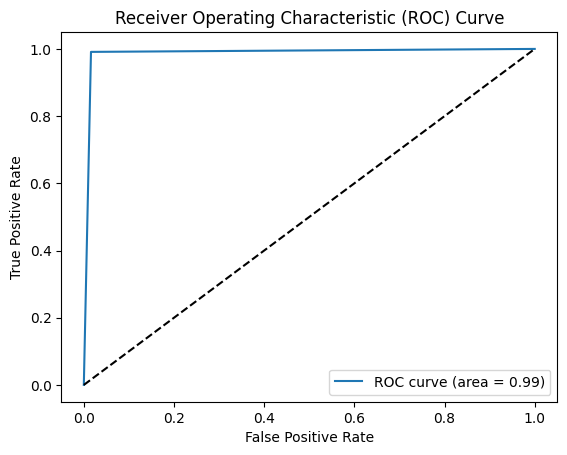

In [62]:
# plot roc auc curve

test_model(logistic_model, X_test, y_test)

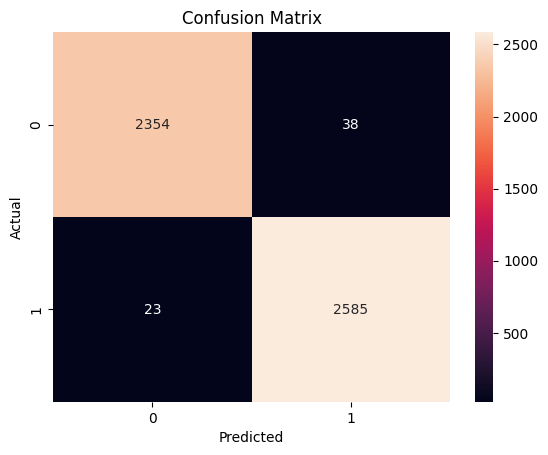

In [67]:
# confusion matrix

cm_logistic = confusion_matrix(y_test, y_pred_logistic)
sns.heatmap(cm_logistic, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Very high accuracy on test data (Held-out) test set**

In [ ]:
y_pred_train = logistic_model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


#### **100% accuracy on train set with logistic regression**

In [39]:
# train logistic regression with title

logistic_model_title = LogisticRegression()
logistic_model_title.fit(X_train_title, y_train_title)



LogisticRegression()

In [40]:
# checking what happens with title with logistic regression
y_pred_logistic_title = logistic_model_title.predict(X_test_title)

accuracy_title = accuracy_score(y_test_title, y_pred_logistic_title)
print(f'Accuracy: {accuracy_title * 100:.2f}%')

Accuracy: 98.64%


### **Better than Naive Bayesian classifier**

In [41]:
# Checking on the train set of title
y_pred_train_title = logistic_model_title.predict(X_train_title)

accuracy_train_title = accuracy_score(y_train_title, y_pred_train_title)
print(f'Accuracy: {accuracy_train_title * 100:.2f}%')

Accuracy: 99.71%


In [71]:
# Applying 5-fold cross-validation to evaluate the performance of the model

from sklearn.model_selection import cross_val_score, cross_val_predict

kfold_model = LogisticRegression()

# Perform 5-fold cross-validation
scores = cross_val_score(kfold_model, X_test, y_test, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

Cross-validation scores: [0.96  0.965 0.969 0.968 0.952]


Accuracy: 0.96
Precision: 0.97
Recall: 0.95
F1-score: 0.96
ROC AUC: 0.96


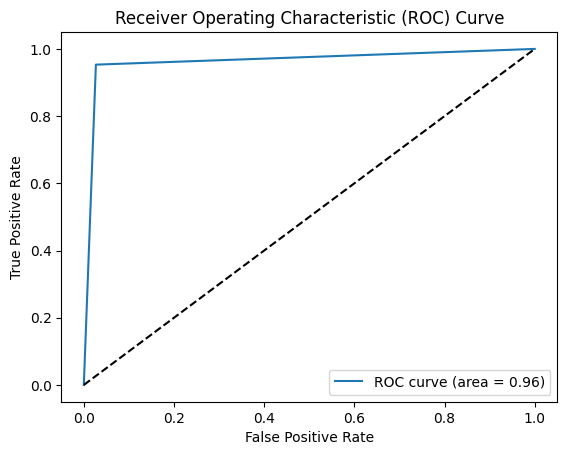

In [72]:
# Evaluate the model using metrics such as accuracy, precision, recall, F1-score, ROC curve and ROC AUC.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_kfold = cross_val_predict(kfold_model, X_test, y_test, cv=5)

accuracy = accuracy_score(y_test, y_pred_kfold)
precision = precision_score(y_test, y_pred_kfold)
recall = recall_score(y_test, y_pred_kfold)
f1 = f1_score(y_test, y_pred_kfold)
roc_auc = roc_auc_score(y_test, y_pred_kfold)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_kfold)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend()
plt.show()


In [73]:
# classification report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_kfold))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2392
           1       0.97      0.95      0.96      2608

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



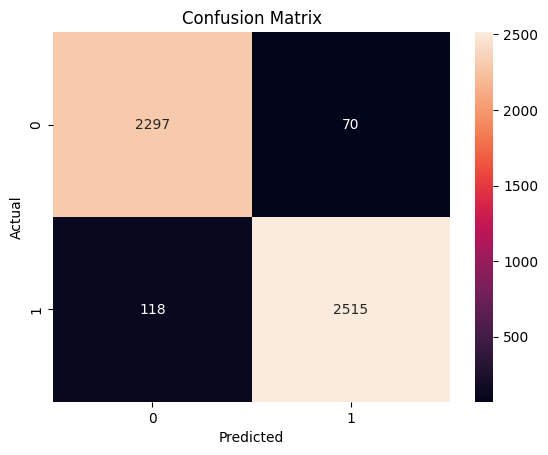

In [54]:
# confusion matrix heatmap

cm_kfold = confusion_matrix(y_test, y_pred_kfold)
sns.heatmap(cm_kfold, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **--------------------  Task 4 ----------------------**

Accuracy Logistic Regression: 98.66%
Accuracy Naive Bayes: 94.06%


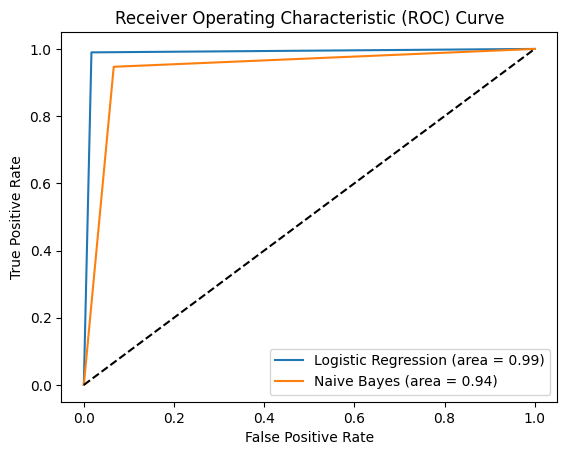

In [55]:
'''Comparing the performance of the Naive Bayes and Logistic Regression classifiers'''

y_pred_logistic = logistic_model.predict(X_test)
y_pred_naive_bayes = model_with_kf.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)

print(f'Accuracy Logistic Regression: {accuracy_logistic * 100:.2f}%')
print(f'Accuracy Naive Bayes: {accuracy_naive_bayes * 100:.2f}%')

#ploting the roc curve
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
fpr_naive_bayes, tpr_naive_bayes, thresholds_naive_bayes = roc_curve(y_test, y_pred_naive_bayes)

plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_score(y_test, y_pred_logistic):.2f})')
plt.plot(fpr_naive_bayes, tpr_naive_bayes, label=f'Naive Bayes (area = {roc_auc_score(y_test, y_pred_naive_bayes):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend()
plt.show()

Accuracy Logistic Regression Fake News: 99.12%
Accuracy Naive Bayes Fake News: 95.40%


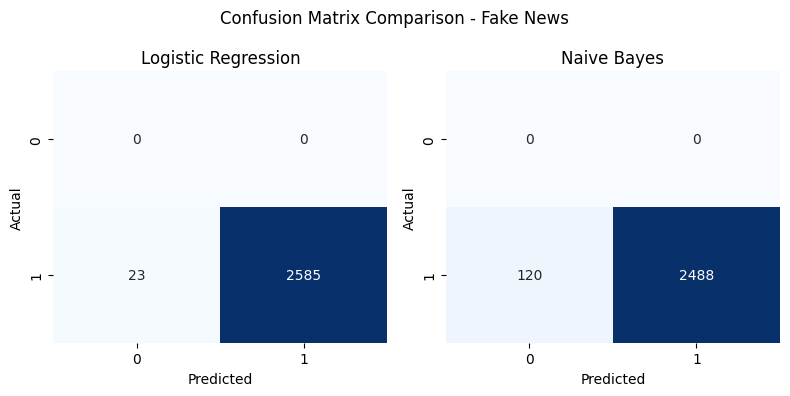

In [81]:
# extracting fake_news from X_train with y_test = 1 (fake news)
fake_news_test = X_test[y_test == 1]

# predict fake_news_test with logistic and naive bayes and comparing the results
y_pred_logistic_fake_news = logistic_model.predict(fake_news_test)
y_pred_naive_bayes_fake_news = model_with_kf.predict(fake_news_test)

accuracy_logistic_fake_news = accuracy_score(y_test[y_test == 1], y_pred_logistic_fake_news)
accuracy_naive_bayes_fake_news = accuracy_score(y_test[y_test == 1], y_pred_naive_bayes_fake_news)

print(f'Accuracy Logistic Regression Fake News: {accuracy_logistic_fake_news * 100:.2f}%')
print(f'Accuracy Naive Bayes Fake News: {accuracy_naive_bayes_fake_news * 100:.2f}%')

# confusion matrix comparision between logistic model and naive bayes

cm_logistic_fake_news = confusion_matrix(y_test[y_test == 1], y_pred_logistic_fake_news)
cm_naive_bayes_fake_news = confusion_matrix(y_test[y_test == 1], y_pred_naive_bayes_fake_news)

plt.figure(figsize=(8, 4))
plt.suptitle('Confusion Matrix Comparison - Fake News')

plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic_fake_news, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_naive_bayes_fake_news, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# **--------------------  Task 5 ----------------------**

## **Ensemble method using Voting Classifier on Naive Bayes and Logistic Regression**

Ensemble Accuracy (Voting): 96.94%
Ensemble ROC AUC: 0.97


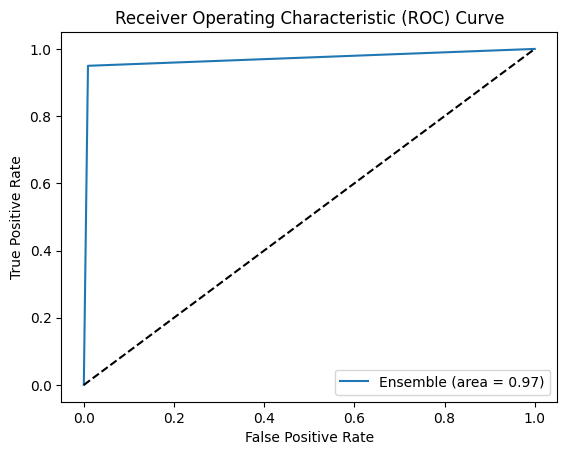

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2392
           1       0.99      0.95      0.97      2608

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [80]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('nb', model_with_kf),
    ('lr', logistic_model)
], voting='hard') # Use 'hard' voting

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = voting_classifier.predict(X_test)

# Evaluate the ensemble
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy (Voting): {accuracy_ensemble * 100:.2f}%")

# Calculate ROC AUC for the ensemble
roc_auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)
print(f"Ensemble ROC AUC: {roc_auc_ensemble:.2f}")

# Generate the ROC curve plot for the ensemble
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_pred_ensemble)
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (area = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_test, y_pred_ensemble))

In [67]:
# # save naive bayes, logistic trainded model


# import pickle

# pickle.dump(model_with_kf, open('naive_bayes_model.pkl', 'wb'))
# pickle.dump(logistic_model, open('logistic_model.pkl', 'wb'))

# # dump count vectorizer and tfidf

# pickle.dump(count_vectorizer, open('count_vectorizer.pkl', 'wb'))
# pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))


In [68]:
# # Load the logistic model
# with open('logistic_model.pkl', 'rb') as model_file:
#     loaded_model = pickle.load(model_file)

# # Load the CountVectorizer
# with open('count_vectorizer.pkl', 'rb') as vectorizer_file:
#     loaded_vectorizer = pickle.load(vectorizer_file)



In [69]:
# Example new text data
new_text_data = ["This is a sample news article to test the model.", "Another example text to check predictions."]

# Transform the new text data using the loaded CountVectorizer
new_data_features = loaded_vectorizer.transform(new_text_data)


In [75]:
# Predict the class for the new text data
predictions = loaded_model.predict(new_data_features)
print(predictions)  # Output predicted labels for each piece of text


[1 1]


### **Checking if news (fake and true) are linearly separable using PCA**

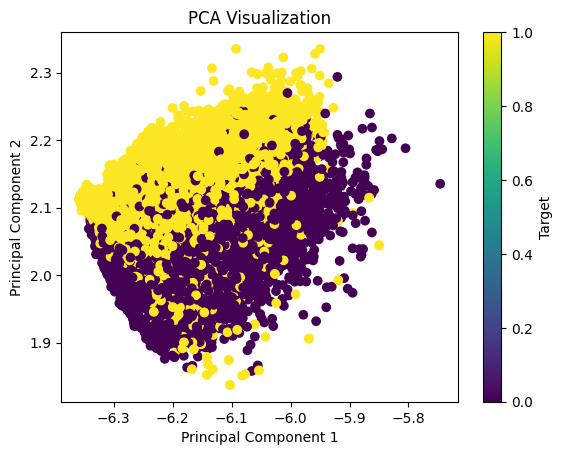

In [81]:
# applying pca to count vectorizer

from sklearn.decomposition import PCA

# Initialize PCA with the 2 components
pca = PCA(n_components=2)

# Fit PCA on count matrix
pca.fit(count_matrix)

# Transform the data using PCA
pca_data = pca.transform(tfidf_matrix)

# plotting pca principle components with y_labels (target)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=target, cmap='viridis')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.colorbar(label='Target')
plt.show()